In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import collections
import pandas as pd
import statistics

## define the model

In [2]:
batch_size = 500

In [3]:
#ToTensor: Grayscale image (RGB 0)~255 to 0~Normalize to the range of 1), Normalize: Z-value (RGB mean and standard deviation to 0).Normalize with 5)
transform = transforms.Compose([transforms.ToTensor()])#, transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Download training data
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


#Download test data
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
#Training dataset: 50,000 RGB images with 32 pixels in height and width
print(train_dataset.data.shape)
(50000, 32, 32, 3)

#Test dataset: 10000 RGB images with 32 pixels in height and width
print(test_dataset.data.shape)
(10000, 32, 32, 3)

#Check the class list
print(train_dataset.classes)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#Classes are often used, so keep them separately
classes = train_dataset.classes

(50000, 32, 32, 3)
(10000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

c3-16 -> bn -> c16-16 -> bn -> mp -> c16-32 -> bn
-> c32-32 -> bn -> mp -> c32-64 -> bn -> c64-64 -> bn
-> mp -> c64-128 -> bn -> c128-128 -> bn
-> aap -> flatten -> fc128-10 -> cross entropy loss

In [7]:

# #Implement CNN
# class Cifar10CnnModel(ImageClassificationBase):
#     def __init__(self):
        
#         super().__init__()
#         self.network = nn.Sequential(
        
#         collections.OrderedDict(
#             [
#                 ("conv_1" ,   nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)),
#                 #("batch_1",   nn.BatchNorm2d(16)),
#                 ("relu_1" ,   nn.ReLU()), 

#                 ("conv2" ,    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)),
#                 #("batch2",    nn.BatchNorm2d(16)) ,           
#                 ("relu2",    nn.ReLU()),

#                 ("maxpool1",    nn.MaxPool2d(2, 2)),

#                 ("conv3" ,    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)),
#                 #("batch3",    nn.BatchNorm2d(32)),      
#                 ("relu3",    nn.ReLU()),
                   
#                 ("conv4" ,   nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)),
#                 #("batch4",    nn.BatchNorm2d(32)),  
#                 ("relu4",   nn.ReLU()),
                
#                 ("maxpool2",    nn.MaxPool2d(2, 2)),

#                 ("conv5" ,   nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)),
#                 #("batch5",    nn.BatchNorm2d(64)),      
#                 ("relu5",    nn.ReLU()),
                
#                 ("conv6" ,   nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)),
#                 #("batch6",    nn.BatchNorm2d(64)),              
#                 ("relu6",    nn.ReLU()),
#                 ("maxpool3",    nn.MaxPool2d(2, 2)),

#                 ("conv7",    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)),
#                 #("batch7",    nn.BatchNorm2d(128)),      
#                 ("relu7",    nn.ReLU()),
                   
#                 ("conv8",    nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)),
#                 #("batch8",    nn.BatchNorm2d(128)),
#                 ("relu8",    nn.ReLU()),
#                  ("aap1",   nn.AdaptiveAvgPool2d(1)),

#                  ("flatten1",   nn.Flatten()),
#                  ("fc1",   nn.Linear(128, 10))
#                 ]
#             )
#         )
        
#     def forward(self, x):
#         return self.network(x)

# model = Cifar10CnnModel()
# model


In [8]:
#Implement CNN
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        
        super().__init__()
        self.network = nn.Sequential(
        
                nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, ),
                nn.BatchNorm2d(16),
                nn.ReLU(), 

                nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(16),           
                nn.ReLU(),

                nn.MaxPool2d(2, 2),

                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(32),      
                nn.ReLU(),
                   
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(32),  
                nn.ReLU(),
                
                nn.MaxPool2d(2, 2),

                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),      
                nn.ReLU(),
                
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),              
                nn.ReLU(),
                nn.MaxPool2d(2, 2),

                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),      
                nn.ReLU(),
                   
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.AdaptiveAvgPool2d(1),

                nn.Flatten(),
                nn.Linear(128, 10)
                )
        
    def forward(self, x):
        return self.network(x)

model = Cifar10CnnModel()
model


Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [9]:
for layer in list(model._modules.items()):
    print(layer)

('network', Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(64, eps=1e-05, mome

In [10]:
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

In [11]:
for name, param in model.named_children():
    print(name)
    print(param)

network
Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(64, eps=1e-05, momentum

# train the model

In [12]:
random_seed = 1487
torch.manual_seed(random_seed);

In [13]:
from torch.utils.data import random_split

val_size = 5000
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)


(45000, 5000)

In [14]:
from torch.utils.data.dataloader import DataLoader
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4,pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size,num_workers=4,pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size,num_workers=4,pin_memory=True)

In [15]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        print(images.shape)
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

torch.Size([500, 3, 32, 32])


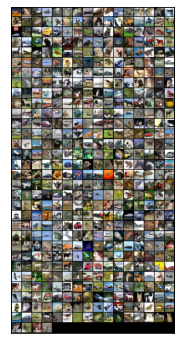

In [16]:
show_batch(train_dl)

In [17]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([500, 3, 32, 32])
out.shape: torch.Size([500, 10])
out[0]: tensor([ 0.1079, -0.0298, -0.2827, -0.1957,  0.0629, -0.1618, -0.0505, -0.1930,
         0.0026,  0.2053], grad_fn=<SelectBackward0>)


In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)
test_dl = DeviceDataLoader(test_dl,device)

# Train the model

In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [22]:
model = to_device(Cifar10CnnModel(), device)

## Estalish baseline - accuracy without training

In [ ]:
evaluate(model, val_dl)

In [ ]:
evaluate(model, test_dl)

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
#Cross entropy

num_epochs = 20

lr = 0.0001
opt_func = torch.optim.Adam


In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    lrs = []
    optimizer = opt_func(model.parameters(), lr)
    
    
    #scheduler_2 = ReduceLROnPlateau(optimizer)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()       
            optimizer.zero_grad()
        
                
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        lrs.append(optimizer.param_groups[0]["lr"])
        
        
        model.epoch_end(epoch, result)
        history.append(result)
        
    #torch.optim.swa_utils.update_bn(loader, swa_model)
    # Use swa_model to make predictions on test data
    #preds = swa_model(test_input)    
    return history,lrs

In [ ]:
history,lrs = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

## plot learning rate

In [ ]:
plt.plot(range(num_epochs),lrs)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

## predict_image

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
xb = to_device(img.unsqueeze(0), device)
# Get predictions from model
yb = model(xb)
# Pick index with highest probability
_, preds  = torch.max(yb, dim=1)
print('Label:', test_dataset.classes[label], ', Predicted:', test_dataset.classes[preds[0].item()])

In [ ]:
torch.save(model.state_dict(), 'cifar10-cnn_2b.pth')

In [ ]:
model2 = to_device(Cifar10CnnModel(), device)
model2.load_state_dict(torch.load('cifar10-cnn_2b.pth'))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size), device)
evaluate(model2, test_loader)

# Average of absolute values of activation at each layer, for ALL training data

In [ ]:
layer_names = []
for name, layer in model.network.named_children(): 
    if isinstance(layer, torch.nn.ReLU):
        layer_names.append(layer) # Names of the layers, so you can have them as part of your plot

In [ ]:
abs_avgs_batch = []
for batch, labels in train_dl:
    abs_avgs_layers = []
    for name, layer in model.network.named_children():
        batch = layer(batch)
        if isinstance(layer, torch.nn.ReLU):
            activations = torch.mean(torch.abs(batch)).cpu().detach()
            abs_avgs_layers.append(activations)
    abs_avgs_batch.append(abs_avgs_layers)
        
#abs_avgs.append(np.average(np.absolute(act.numpy().flatten())))

In [ ]:
abs_avgs=torch.mean(torch.FloatTensor(abs_avgs_batch),dim=0)
df = pd.DataFrame(list(zip(layer_names, abs_avgs.numpy())), columns = ['Layers',  'Average Absolute Values of Activations'])

In [ ]:
df

In [ ]:
abs_avgs.numpy()

In [ ]:
torch.var(abs_avgs)

## visulize intermidate activations

In [ ]:
for batch, labels in train_dl:
    print(batch.shape)
    break
print(batch.shape)

In [ ]:
model.network

In [ ]:
batch.shape

In [ ]:
def show_activations(layer_name, features):
    activations = torch.mean(torch.abs(features), dim=0).cpu().detach()
    num_activations = activations.shape[0]
    #fig = plt.figure(figsize=(30, 5))
    columns = 16
    rows = num_activations // 16 + 1
    fig = plt.figure(figsize=(30, 2*rows))
    plt.axis('off')
    plt.title(layer_name)

    for i in range(num_activations):
        fig.add_subplot(rows, columns, int(i)+1)

        plt.imshow(activations[i],interpolation='nearest')
    plt.tight_layout()
    plt.grid(False)   

In [ ]:
for batch, labels in train_dl:
    for name, layer in model.network.named_children():
        batch = layer(batch)
        if isinstance(layer, torch.nn.ReLU):
            show_activations(name, batch)
    break